# 数据同化的算法演变：3DVar、EKF、EnKF

> 海洋学院，沈浙奇，2024年6月，zqshen@hhu.edu.cn

## 关于同化流程的代码回顾
[前面的脚本](https://curian127.github.io/DemoUsingL63.html)给了一份完整说明：关于Lorenz63模式如何运行，以及如何构造孪生数值实验来展示混沌效应和数据同化。在理解那些代码的基础上，就不难通过分析不同的同化算法代码来了解它们具体的原理和假设。在开始讨论同化算法之前，我展示必要的几块代码，包括: 1.模式定义；2.构造观测；3.定义同化算法3DVar；4.开展同化实验。使用这几块代码展示一下一个典型的同化实验（基本上也就是挑出之前的脚本的关键部分）。

In [1]:
# 定义模式方程和积分格式
import numpy as np
def Lorenz63(state,*args):       #Lorenz63模式
    sigma = args[0]
    beta = args[1]
    rho = args[2]
    x, y, z = state 
    f = np.zeros(3) 
    f[0] = sigma * (y - x)
    f[1] = x * (rho - z) - y
    f[2] = x * y - beta * z
    return f 
def RK4(rhs,state,dt,*args):    # Runge-Kutta格式，输入的rhs代表模式右端方程
    k1 = rhs(state,*args)
    k2 = rhs(state+k1*dt/2,*args)
    k3 = rhs(state+k2*dt/2,*args)
    k4 = rhs(state+k3*dt,*args) # 输出新的一步的状态
    new_state = state + (dt/6)*(k1+2*k2+2*k3+k4)
    return new_state

# 之后使用 RK4(Lorenz63,x_in,dt,sigma,beta,rho)可以进行步长为dt的一步积分

In [2]:
# Lorenz63模式真值试验和观测构造
sigma = 10.0; beta = 8.0/3.0; rho = 28.0          # 模式参数值   
dt = 0.01                                         # 模式积分步长
n = 3                                             # 模式的状态维数，即有多少个状态变量
m = 3                                             # 模式的观测维数，即多少个变量可以被观测到，这里先假定所有变量都能被观测
tm = 10                                           # 同化试验时间窗口
nt = int(tm/dt)                                   # 总积分步数
t = np.linspace(0,tm,nt+1)                        # 模式时间网格
x0True = np.array([1.508870, -1.531271, 25.46091])# 真实值的初值
np.random.seed(seed=1)              # 设置随机种子，由于电脑的随机数是伪随机，记录了随机种子之后，每次运行这个脚本产生的“随机”的观测误差都是一样的。
sig_m= 0.5                                        # 观测误差标准差
R = sig_m**2*np.eye(n)                            # 观测误差协方差矩阵，设为对角阵使得不同变量的误差互不相干
dt_m = 0.2                                        # 观测之间的时间间隔（即每20模式步观测一次）
tm_m = 10                                         # 最大观测时间（即多少时间之后停止同化，可小于同化试验时间窗口）
nt_m = int(tm_m/dt_m)                             # 进行同化的总次数
ind_m = (np.linspace(int(dt_m/dt),int(tm_m/dt),nt_m)).astype(int)   # 这是有观测的时刻在总时间网格中的位置指标
t_m = t[ind_m]                                                      # 观测网格
def h(x):                                         # 定义观测算子：观测算子用于构建模式变量和观测之间的关系。当所有变量被观测时，使用单位阵。
    H = np.eye(n)                                 # 观测矩阵为单位阵。
    yo = H@x                                      # 单位阵乘以状态变量，即所有变量直接被观测。
    return yo
Xtrue = np.zeros([n,nt+1])                        # 真值保存在xTrue变量中
Xtrue[:,0] = x0True                               # 初始化真值
km = 0                                            # 观测计数
yo = np.zeros([3,nt_m])                           # 观测保存在yo变量中
for k in range(nt):                               # 按模式时间网格开展模式积分循环
    Xtrue[:,k+1] = RK4(Lorenz63,Xtrue[:,k],dt,sigma,beta,rho)       # 真实值积分
    if (km<nt_m) and (k+1==ind_m[km]):                              # 用指标判断是否进行观测
        yo[:,km] = h(Xtrue[:,k+1]) + np.random.normal(0,sig_m,[3,]) # 通过判断，在观测时间取出真值作为观测值，同时叠加高斯分布随机噪声
        km = km+1                                                   # 观测计数，用于循环控制
        
# 这个脚本产生了同化实验中的观测数据yo和用于对比结果的真值Xtrue。

In [3]:
def Lin3dvar(xb,w,H,R,B):                  # 三维变分同化算法
    A = R + H@B@(H.T)
    b = (w-H@xb)
    xa = xb + B@(H.T)@np.linalg.solve(A,b) # 求解线性方程组
    return xa
# 由于我并不打算过于详细地介绍3DVar的各种算法细节，我只使用最简单的一个版本展开介绍

In [4]:
# 同化实验流程
x0b = np.array([1,-1,20])                # 背景积分的初值
Xb = np.zeros([3,nt+1]); Xb[:,0] = x0b   # 控制试验结果存在xb中
# --------------- 背景积分实验 ------------------------
for k in range(nt):                      # 模式积分循环
    Xb[:,k+1] = RK4(Lorenz63,Xb[:,k],dt,sigma,beta,rho)   # 不加同化的背景积分结果，后面和同化结果进行对比
# --------------- 数据同化实验 ------------------------
sig_b= 1.0                               # 设定初始的背景误差
B = sig_b**2*np.eye(3)                   # 设定初始背景误差协方差矩阵，B矩阵的取值对于变分同化比较重要，这个简单模式可以使用简单的对角阵
Xa = np.zeros([3,nt+1]); Xa[:,0] = x0b   # 同化试验结果存在Xa中，第一步没同化，所以数值也是x0b
km = 0                                   # 同化次数计数
H = np.eye(3)                            # 如前述，观测算子是单位阵
for k in range(nt):                      # 模式积分循环
    Xa[:,k+1] = RK4(Lorenz63,Xa[:,k],dt,sigma,beta,rho)   # 没有遇到观测的时候，就是正常积分模式
    if (km<nt_m) and (k+1==ind_m[km]):   # 当有观测时，使用3dvar同化
        Xa[:,k+1] = Lin3dvar(Xa[:,k+1],yo[:,km],H,R,B)  # 调用3dvar，更新状态和协方差
        km = km+1

前面四个代码框已经完成了整个同化实验，下面的画图只是为了用一种更可视化的方式把结果表示出来。一方面，展示将真实值、观测值、背景积分、同化分析展示在一张图上，直观展示它们的差别。另一方面，用均方根误差来量化它们之间的差异。画图的一个参考脚本如下：

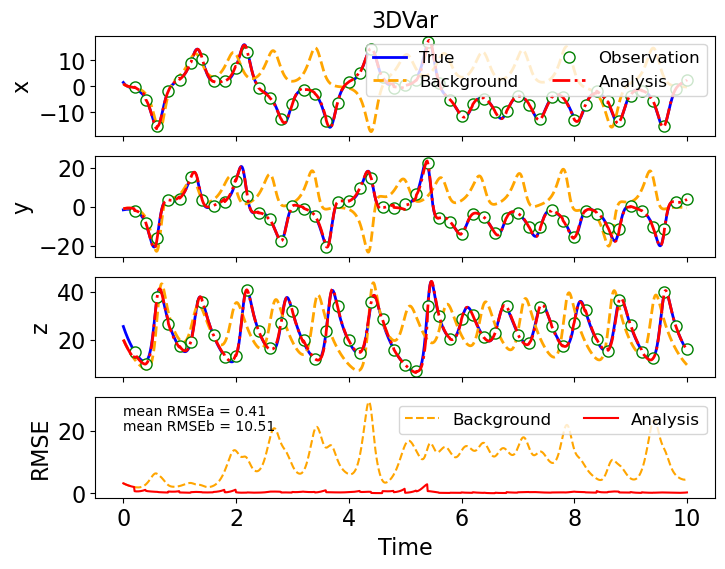

In [5]:
RMSEb = np.sqrt(np.mean((Xb-Xtrue)**2,0))
RMSEa = np.sqrt(np.mean((Xa-Xtrue)**2,0))
# 结果画图
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
lbs = ['x','y','z']
for j in range(3):
    plt.subplot(4,1,j+1)
    plt.plot(t,Xtrue[j],'b-',lw=2,label='True')
    plt.plot(t,Xb[j],'--',color='orange',lw=2,label='Background')
    plt.plot(t_m,yo[j],'go',ms=8,markerfacecolor='white',label='Observation')
    plt.plot(t,Xa[j],'-.',color='red',lw=2,label='Analysis')
    plt.ylabel(lbs[j],fontsize=16)
    plt.xticks(np.arange(0,10.1,2),[]);plt.yticks(fontsize=16)
    if j==0:
        plt.legend(ncol=2, loc='upper right',fontsize=12)
        plt.title("3DVar",fontsize=16)
plt.subplot(4,1,4)
plt.plot(t,RMSEb,'--',color='orange',label='Background')
plt.plot(t,RMSEa,color='red',label='Analysis')
plt.text(0,20,'mean RMSEb = %0.2f' %np.mean(RMSEb))
plt.text(0,25,'mean RMSEa = %0.2f' %np.mean(RMSEa))
plt.ylabel('RMSE',fontsize=16)
plt.xlabel('Time',fontsize=16)
plt.xticks(fontsize=16);plt.yticks(fontsize=16)
plt.legend(ncol=2, loc='upper right',fontsize=12)

对比第二个框（造观测）和第四个框（同化实验）中的`for循环`，

* 前者是在一直进行真值积分，判断观测时刻则取样产生观测
* 后者是在一直进行背景积分，判断观测时刻则调用同化算法，将背景积分值和观测值结合产生分析值。分析值替换背景值后，会直接进入积分过程。

## 三维变分

那么，我们可以关心一下`lin3dvar`做了什么，看代码可以直接看到$x^b$和$y$组合的公式如下

$$x^a = x^b+BH^T(R+HBH^T)^{-1}(y-Hx^b)     \qquad (1)$$

其中的$R$是观测误差协方差，在我们造观测的第二个框中定义。$H$是观测算子，我们的实验中是单位矩阵。$B$也是我们定义的一个矩阵，被称为背景误差协方差矩阵。

最优状态估计$x^a$是通过最小化以下关于$x$的代价函数$J(x)$得到:

$$J(x)=\frac12(x-x^\mathrm{b})B^{-1}(x-x^\mathrm{b})^\mathrm{T}+\frac12(y-Hx^\mathrm{b})R^{-1}(y-Hx^\mathrm{b})   \qquad (2)$$

代价函数以误差协方差为权重组合了背景误差和观测误差。变分方法构建代价函数来描述状态量分析值和真值之间的差异，利用变分思想把数据同化问题转 化为极值求解问题。
变分同化方法在数据同化中具有非常重要的意义。该方法的命名来自数学中的变分法。变分法是17世纪末发展起来的一门数学分支，是处理泛函的数学领 域。它最终寻求的是极值函数，它们使得泛函取得极大值或极小值。

通过求解$\frac{\partial J(x)}{\partial x}=0$，可以得到上面的表达式(1)。

三维变分中的”三维“主要指代空间，意味着它不考虑一段时间内的数据同化，而只把每次同化的窗口设置在一个瞬时 —— 即使用某个瞬时的所有观测，更新这个瞬时的状态。大致的示意图如下，即模式积分到有观测的时刻，给出一个”预报“，它和观测结合得到一个分析，然后再进行下一段的模式积分。虽然看上去模式的整个积分路径有不少间断，但是实际上，由于不断纳入观测数据，模式的预报误差会限制在一个比较小的值，每次的调整量实际上是非常小的，不会有示意图中那么明显的不连续。

![fig1](pic/figure_sequential.png)
> 图：三维变分和其他顺序同化方法相空间变化轨迹示意图。

## 卡尔曼滤波器和扩展卡尔曼滤波器
仔细看上述同化方法的公式（1），我们最大的问题可能是 —— $B$究竟是怎么给的？

$B$称为背景误差协方差矩阵，正如其名字表述的那样，其代表了背景场的误差的二阶统计信息 —— 协方差矩阵。也就是说，我们需要提前提供信息说明预报出来的背景场大概有多准或者多不准。然后，它可以在公式（1）中作为权重的一部分，平衡背景场和观测值。$B$值相对于$R$值越大，说明背景场越不可靠，它在分析中占的比重就越小；反之，说明背景场精度更高，它能占更大的比重。

Lorenz模式比较简单，因此我们只需要提供一个大致的$B$矩阵就能达到同化的目的（甚至它还是对角阵）。是如果要针对更复杂模式开展同化，这种随便给的$B$矩阵肯定是不行的。需要用更精准的方式给定$B$矩阵。

特别地，读者可能还注意到了在整个同化过程中$B$矩阵是静态的，不会随着同化或者积分的进程而改变。这显然也是不符合实际的，因为它意味着背景场的不确定性也是恒定不变的。这种$B$矩阵恒定不变的特性叫做“非流依赖性”（non-flow-dependent）。

从这个词来说，其对立面“流依赖性”或者（flow-dependent）显然意味着背景误差协方差会随着模式积分而变化的这一种情况。对应的同化方法被称为卡尔曼滤波器（Kalman Filter, KF）。

我不打算过多介绍这种方法的细节，关于这方面的教材已经很多了，我直接把对应的公式放在下面。

状态空间模型表示为

$$\begin{aligned}\boldsymbol{x}_{k}&=\boldsymbol{Mx}_{k-1},  \qquad (3) \\\boldsymbol{y}_k&=\boldsymbol{Hx}_k,  \qquad \quad (4)  \end{aligned}$$

其中（3）代表第$k-1$步到第$k$步的积分算子，（4）代表第$k$步的观测算子。对应三维变分里面的公式（1），卡尔曼滤波进行同化的时候使用公式如下：

\begin{aligned}
&\boldsymbol{K}=\boldsymbol{P}_k^\mathrm{f}\boldsymbol{H}^\mathrm{T}\left[\boldsymbol{H}\boldsymbol{P}_k^\mathrm{f}\boldsymbol{H}^\mathrm{T}+\boldsymbol{R}\right]^{-1} \qquad (5)\\
&\boldsymbol{x}_k^\mathrm{a}=\boldsymbol{x}_k^\mathrm{f}+\boldsymbol{K}\left[\boldsymbol{y}_k-\boldsymbol{H}\boldsymbol{x}_k^\mathrm{f}\right] \qquad \quad  (6) \\
&\boldsymbol{P}_k^\mathrm{a}=(\mathbf{I}-\boldsymbol{K}\boldsymbol{H})\boldsymbol{P}_k^\mathrm{f} \qquad \qquad\qquad  (7) 
\end{aligned}

(5)-(7)这是同化时刻的分析步骤，(5)和(6)合起来就和（1）的效果相当，只不过静态的$B$换成了动态变化的$\boldsymbol{P}_k^\mathrm{f}$。（7）也是通过（2）的最小化问题可以得到的一个公式，它从背景误差协方差得到分析误差协方差。

然后在后续的模式积分过程中，我们不光需要积分模式，也需要将分析误差协方差矩阵“积分”，以得到下次观测时刻的背景误差协方差。

$$\begin{aligned}&\boldsymbol{x}_{k+1}^\mathrm{f}=\boldsymbol{M}\boldsymbol{x}_{k}^\mathrm{a} \qquad\qquad (8)  \\&\boldsymbol{P}_{k+1}^\mathrm{f}=\boldsymbol{M}\boldsymbol{P}_{k}^\mathrm{a}\boldsymbol{M}^\mathrm{T}+\boldsymbol{Q} \quad (9)\end{aligned}$$

公式（9）发挥的作用是在积分模式的同时，将误差协方差矩阵也进行更新，其中$Q$代表模式误差的协方差矩阵——如果模式本身就有误差，它在积分过程中也会影响背景误差。在卡尔曼滤波器的术语中，（5-7）是分析阶段，(8-9)是预报阶段，两个阶段都需要同时考虑模式状态的期望值和协方差矩阵的演变关系。因此协方差矩阵是流依赖的。其中，公式（5）计算的$K$叫做卡尔曼增益矩阵（Kalman Gain），在分析过程中扮演关键的权重作用。

我当然想展示一下卡尔曼滤波器在Lorenz63模式中的表现，但是现在不行。注意到洛伦茨63模式是一个非线性模式，如下：

$$\frac{dx}{dt}=\sigma(y-x) \qquad (10)$$
$$\frac{dy}{dt}=\rho x-y-xz \qquad (11)$$
$$\frac{dz}{dt}=xy-\beta z \qquad (12)$$

它没有办法被写成（3）的形式。事实上，我们需要用另外的方式表示这个状态空间模型。

$$\begin{aligned}\boldsymbol{x}_{k}&=\mathcal{M}(\boldsymbol{x}_{k-1}),  \qquad (13) \\\boldsymbol{y}_k&=h(\boldsymbol{x}_k),  \qquad \quad (14)  \end{aligned}$$

为了更一般性的问题，我们不妨同时考虑非线性的模式算子$\mathcal{M}(\cdot)$和非线性的观测算子$h(\cdot)$。

处理这种非线性问题的卡尔曼滤波器叫做扩展卡尔曼滤波器，公式如下：
1. 预报阶段
$$\begin{aligned}&x_{k}^{\mathrm{f}}=\mathcal{M}\big(x_{k-1}^{\mathrm{a}}\big) \qquad (15)
\\&M=\frac{\partial\mathcal{M}}{\partial x}\bigg|_{x_{k-1}^{\mathrm{a}}} \qquad (16)
\\&P_{k}^{\mathrm{f}}=MP_{k-1}^{\mathrm{a}}\boldsymbol{M}^{\mathrm{T}}+\boldsymbol{Q}\qquad (17)\end{aligned} $$
2. 分析阶段
$$\begin{aligned}
&H={\frac{\partial h}{\partial x}}\bigg|_{x_{k}^{\mathrm{f}}} \qquad (18)\\
&K=P_{k}^{\mathrm{f}}H^{\mathrm{T}}\left(HP_{k}^{\mathrm{f}}H^{\mathrm{T}}+R\right)^{-1} \qquad (19)\\
&x_{k}^{\mathrm{a}}=x_{k}^{\mathrm{f}}+K\left[y_{k}-h\left(x_{k}^{\mathrm{f}}\right)\right]\qquad (20) \\
&P_{k}^{\mathrm{a}}=(\mathbf{I}-\mathbf{K}\mathbf{H})P_{k}^{\mathrm{f}}\qquad (21)
\end{aligned}$$

和卡尔曼滤波器相比，扩展卡尔曼滤波器只有两处独特的地方，就是公式（15）和（18），分别计算了非线性的$\mathcal{M}(\cdot)$和$h(\cdot)$在积分初始位置的雅克比矩阵的值。我们把对应的矩阵$M$和$H$的左乘分别叫做$\mathcal{M}(\cdot)$和$h(\cdot)$的切线算子。具体到Lorenz63模式，就叫他Lorenz63模式的**切线模式**，由于

$$\boldsymbol{M}=\frac{\partial\boldsymbol{f}}{\partial\boldsymbol{x}}=\begin{bmatrix}\frac{\partial f_1}{\partial x}&\frac{\partial f_1}{\partial y}&\frac{\partial f_1}{\partial z}\\\frac{\partial f_2}{\partial x}&\frac{\partial f_2}{\partial y}&\frac{\partial f_2}{\partial z}\\\frac{\partial f_3}{\partial x}&\frac{\partial f_3}{\partial y}&\frac{\partial f_3}{\partial z}\end{bmatrix}=\begin{bmatrix}-\sigma&\sigma&0\\\rho-z&-1&-x\\y&x&-\beta\end{bmatrix}$$

我们就可以把这个切线模式的代码写出来。

In [6]:
#%% Lorenz63模式的切线性模式
def JLorenz63(state,*args):         # Lorenz63 方程雅克比矩阵
    sigma = args[0]
    beta = args[1]
    rho = args[2]
    x, y, z = state
    
    df = np.zeros([3,3])           # 以下是切线性矩阵的9个元素配置
    df[0,0] = sigma * (-1)
    df[0,1] = sigma * (1)
    df[0,2] = sigma * (0)
    df[1,0] = 1 * (rho - z) 
    df[1,1] = -1
    df[1,2] = x * (-1)
    df[2,0] = 1 * y 
    df[2,1] = x * 1 
    df[2,2] = - beta
    return df 

def JRK4(rhs,Jrhs,state,dt,*args):   # 切线性模式的积分格式    
    n = len(state)
    k1 = rhs(state,*args)
    k2 = rhs(state+k1*dt/2,*args)
    k3 = rhs(state+k2*dt/2,*args)
    # 以下是对矩阵的Runge-Kutta格式
    dk1 = Jrhs(state,*args)
    dk2 = Jrhs(state+k1*dt/2,*args) @ (np.eye(n)+dk1*dt/2) 
    dk3 = Jrhs(state+k2*dt/2,*args) @ (np.eye(n)+dk2*dt/2) 
    dk4 = Jrhs(state+k3*dt,*args) @ (np.eye(n)+dk3*dt)  
    DM = np.eye(n) + (dt/6) * (dk1+2*dk2+2*dk3+dk4)
    return DM

有了切线模式，我们可以仿照3D-Var的方式开展同化实验，不过我们要先提供[3]框对应的扩展卡尔曼滤波器（简称EKF）的分析算法代码：

In [7]:
def EKF(xb,yo,ObsOp,Dh,R,B):
# 输入的变量分别为:xb 预报、yo 观测、ObsOp 观测算子、Dh 切线观测矩阵，R 观测误差协方差， # B 背景误差协方差。
    n = xb.shape[0]                      # 状态空间维数
    D = Dh@B@Dh.T + R
    K = B @ Dh.T @ np.linalg.inv(D)      # 卡尔曼增益矩阵
    xa = xb + K @ (yo-ObsOp(xb))         # 更新状态
    P = (np.eye(n) - K@Dh) @ B           # 更新误差协方差矩阵
    return xa, P                         # 输出分析状态场和分析误差协方差矩阵

注意到EKF的代码中已经加入了公式（21）对应的分析误差协方矩阵的输入，这是3DVar中不具备的。然后，可以使用[4]框中的代码开展EKF的同化实验。区别就在于调用EKF而非3DVar，而且在`Xa[:,k+1] = RK4(Lorenz63,Xa[:,k],dt,sigma,beta,rho) `积分的同时，加入公式（16）-（17）的切线矩阵计算和协方差更新。我直接把[4]框复制过来，然后修改几行就可以用EKF进行同化了，修改的行我用一连串的感叹号标记。

In [8]:
# 同化实验流程
x0b = np.array([1,-1,20])                # 背景积分的初值
Xb = np.zeros([3,nt+1]); Xb[:,0] = x0b   # 控制试验结果存在xb中
# --------------- 背景积分实验 ------------------------
for k in range(nt):                      # 模式积分循环
    Xb[:,k+1] = RK4(Lorenz63,Xb[:,k],dt,sigma,beta,rho)   # 不加同化的背景积分结果，后面和同化结果进行对比
# --------------- 数据同化实验 ------------------------
sig_b= 1.0                               # 设定初始的背景误差
Q = 0.0*np.eye(3)                        # !!!!!!!!!!!!!!!!!!!设置模式误差（若假设完美模式则取0）
B = sig_b**2*np.eye(3)                   # 设定初始背景误差协方差矩阵，B矩阵的取值对于变分同化比较重要，这个简单模式可以使用简单的对角阵
Xa = np.zeros([3,nt+1]); Xa[:,0] = x0b   # 同化试验结果存在Xa中，第一步没同化，所以数值也是x0b
km = 0                                   # 同化次数计数
H = np.eye(3)                            # 如前述，观测算子是单位阵
for k in range(nt):                      # 模式积分循环
    Xa[:,k+1] = RK4(Lorenz63,Xa[:,k],dt,sigma,beta,rho)      # 没有遇到观测的时候，就是正常积分模式
    DM = JRK4(Lorenz63,JLorenz63,Xa[:,k],dt,sigma,beta,rho)  # !!!!!!!!!!!!!!!!!!!!!!!!使用切线性模式积分
    B = DM @ B @ DM.T + Q                                    # !!!!!!!!!!!!!!!!!!!!!!!!积分过程协方差更新
    if (km<nt_m) and (k+1==ind_m[km]):                       # 当有观测时
        Xa[:,k+1],B = EKF(Xa[:,k+1],yo[:,km],h,H,R,B)        # !!!!!!!!!!!!!!!!!!调用EKF，更新状态和协方差
        km = km+1

画图的脚本也是一模一样的，我只需要换个标题就行

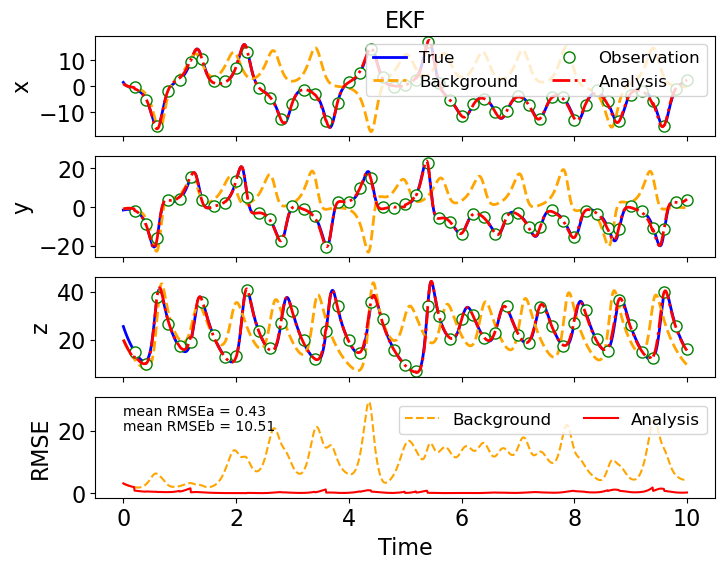

In [9]:
RMSEb = np.sqrt(np.mean((Xb-Xtrue)**2,0))
RMSEa = np.sqrt(np.mean((Xa-Xtrue)**2,0))
# 结果画图
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
lbs = ['x','y','z']
for j in range(3):
    plt.subplot(4,1,j+1)
    plt.plot(t,Xtrue[j],'b-',lw=2,label='True')
    plt.plot(t,Xb[j],'--',color='orange',lw=2,label='Background')
    plt.plot(t_m,yo[j],'go',ms=8,markerfacecolor='white',label='Observation')
    plt.plot(t,Xa[j],'-.',color='red',lw=2,label='Analysis')
    plt.ylabel(lbs[j],fontsize=16)
    plt.xticks(np.arange(0,10.1,2),[]);plt.yticks(fontsize=16)
    if j==0:
        plt.legend(ncol=2, loc='upper right',fontsize=12)
        plt.title("EKF",fontsize=16)     #!!!!!!!!!!!!!!!!!!!!!!!!!!!
plt.subplot(4,1,4)
plt.plot(t,RMSEb,'--',color='orange',label='Background')
plt.plot(t,RMSEa,color='red',label='Analysis')
plt.text(0,20,'mean RMSEb = %0.2f' %np.mean(RMSEb))
plt.text(0,25,'mean RMSEa = %0.2f' %np.mean(RMSEa))
plt.ylabel('RMSE',fontsize=16)
plt.xlabel('Time',fontsize=16)
plt.xticks(fontsize=16);plt.yticks(fontsize=16)
plt.legend(ncol=2, loc='upper right',fontsize=12)

在Lorenz63模式这种小型模式中，因为变量较少，即使使用3DVar也能达到比较好的同化效果。

但是现实的模式很难构造恰当的$B$矩阵，特别是难以构造变量之间的相关。所以现实中3DVar的效果非常依赖于$B$的选取。而EKF由于有流依赖性，所以从原理上来看，它是更合理的，而且它的误差协方差矩阵会随着模式积分演化。因此哪怕初始提供的是一个对角阵，它也会逐渐演化出变量之间的相关。不妨看看实验结束时刻的$B$矩阵数值，如下：

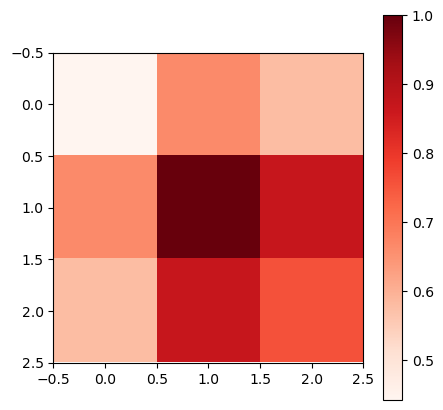

In [10]:
plt.figure(figsize=(5,5))
plt.imshow(B/np.max(B),cmap='Reds')
plt.colorbar()

可以明显看出变量之间的相关。

这里的扩展卡尔曼滤波器实际上是理论上的卡尔曼滤波器在非线性情况下的必要改进，不然它就没法被用到非线性模式中。所以后面我不特意提“扩展”两个字，凡是提到卡尔曼滤波器的时候，默认就包括了扩展卡尔曼滤波器。

## 集合卡尔曼滤波器

从解决问题的角度看，三维变分可以实现同化的功能，但它的问题是提供背景误差协方差矩阵的方法不够客观，人为的因素容易导致结果不可靠。

卡尔曼滤波器（KF和EKF）相比于三维变分，加上了背景误差协方差的流依赖特性，从理论上说，它不再是一种三维方法，称得上是四维的同化方法。另外有一种非常有名的同化方法叫做四维变分，但是我不打算现在在这里展开。我们还是从EKF的不足谈起，并引入对应的新算法。

那么，EKF的不足是什么呢?从代码里面看。
* [6]框显得非常麻烦，3D-Var在任何情况下都不需要这个切线模式；但只要模型是非线性的，EKF就必须使用这个切线模式来更新$B$矩阵。Lorenz63模式的方程简单，这个切线模式较容易写。但是如果是对非常复杂的大型模式开展同化，编写一个切线模型的工作量是非常惊人的。
* 实验代码中的`B = DM @ B @ DM.T + Q `这段。对于Lorenz63模式来说无足轻重。但是对于可能有几百万个方程几千万个变量的大型模式来说，计算量非常巨大，需要占用的内存（$B$的变量数是模式变量$x$的维数的平方）也是令人望而生畏的
* 即使你不担心计算量，EKF的效果也不一定好。因为切线模式只是非线性模式的近似，如果模型的非线性越来越大，这种近似带来的误差也是很大的，而且会随着同化的流程积累起来，导致后面的效果会崩溃。

所以EKF的万恶之源还是在用切线模式演化$B$矩阵上面，只要是使用稍微大一点儿的有实际预报意义的模式开展同化，EKF就力不从心了。

但是，流依赖性是卡尔曼滤波器的核心，有没有特殊的办法使$B$矩阵可以演化，又不需要切线模式$M$，最好又能不占用巨大的内容来保存$B$呢？

答案就在这部分的标题 —— 集合卡尔曼滤波器（Ensemble Kalman Filter, EnKF）里。EnKF 的基本思想是使用概率空间内的点表示状态变量的一种可能。在这一思想下，EnKF最革命性的工作是使用集合来估计预报误差协方差矩阵。如果将时间步$k$的集合预报表示为$X^f=\{x^f_1 ,x^f_2 ,\ldots,x^f_N\}$，其中$x^f_i$ 代表预报集合的第$i$个成员（总共有$N$个成员），那么背景误差协方差的近似值可以如下计算

$$\begin{gathered}
P_{\mathrm{e},k}^{\mathrm{f}}\equiv\frac{1}{N-1}\sum_{i=1}^{N}\Bigl(x_{k,i}^{\mathrm{f}}-\overline{{x_{k}^{\mathrm{f}}}}\Bigr)\Bigl(x_{k,i}^{\mathrm{f}}-\overline{{x_{k}^{\mathrm{f}}}}\Bigr)^{\mathrm{T}} \\
=\frac{1}{N-1}\Big(X_{k}^{\mathrm{f}}-\overline{{X_{k}^{\mathrm{f}}}}\Big)\Big(X_{k}^{\mathrm{f}}-\overline{{X_{k}^{\mathrm{f}}}}\Big)^{\mathrm{T}} 
\end{gathered}  \qquad (22)$$

有了这个公式，每当需要同化更新的时候，只需要用（22）计算得到的$P$矩阵（实质上相当于前面一直说的$B$矩阵）代入到（1）或者（5-6）或者（19-20）就可以实现同化更新（这三个式子就是一回事）。

那么，$P$矩阵怎么演化呢，`B = DM @ B @ DM.T + Q `这个用什么代替呢？EnKF给出的答案就是不要了，在EnKF中，流依赖性不是体现在更新协方差里面，而是更新状态集合，然后利用不断变化的状态集合来用（22）式随时计算协方差。

也就是说，在EKF中只需要积分一份数值模式(`Xa[:,k+1] = RK4(Lorenz63,Xa[:,k],dt,sigma,beta,rho)`)和一份切线模式(`DM = JRK4(Lorenz63,JLorenz63,Xa[:,k],dt,sigma,beta,rho)`)，而在EnKF中，免去了后者，改成积分N份的数值模式。

Lorenz63模式无法提现其中的计算成本。但是如前面说的，实际模式中，切线模式的积分是平方倍的计算量，变量数多的时候会变成天文数值。而在EnKF中，实际上$N$只要有数十个或者数百个就行了。还是比较有限的计算量。两者对比，还是EnKF可行性更高。此外，EnKF不涉及到切线模式的截断误差，对于非线性模式也没有太大障碍。

那么下面提供EnKF的分析算法：

In [11]:
def EnKF(xbi,yo,ObsOp,Dh,R):
# 输入变量依次为预报集合、观测、观测算子、切线观测矩阵、观测误差协方差
    n,N = xbi.shape                        # n-状态维数，N-集合成员数
    m = yo.shape[0]                        # m-观测维数
    xb = np.mean(xbi,1)                    # 计算预报集合平均                      
    B = (1/(N-1)) * (xbi - xb.reshape(-1,1)) @ (xbi - xb.reshape(-1,1)).T

    #背景误差协方差
    D = Dh@B@Dh.T + R
    K = B @ Dh.T @ np.linalg.inv(D) #计算卡尔曼增益矩阵
    yoi = np.zeros([m,N])                                                # 预分配空间，保存扰动后的观测集合 xai = np.zeros([n,N]) 
    for i in range(N):
        yoi[:,i] = yo + np.random.multivariate_normal(np.zeros(m), R)        # 随机扰动观测
        xai[:,i] = xbi[:,i] + K @ (yoi[:,i]-ObsOp(xbi[:,i]))                 # 更新每个成员
    return xai                            # 输入和输出都是一整个集合。不同于 EKF，不需要输出分析误差协方差

EnKF的同化流程和EKF的差别反而大于和3DVar的，可以对照框[4]来看EnKF的同化实验。不同之处看一连串叹号包围的部分。差别其实也只有7行，重点在于通过扰动产生集合成员的部分，以及积分过程中要积分所有集合成员，并且同化时调用EnKF同时更新所有成员。

然后后面的画图脚本也基本上是一模一样。

In [27]:
# EnKF同化实验流程
x0b = np.array([1,-1,20])                # 背景积分的初值
Xb = np.zeros([3,nt+1]); Xb[:,0] = x0b   # 控制试验结果存在xb中
# --------------- 背景积分实验 ------------------------
for k in range(nt):                      # 模式积分循环
    Xb[:,k+1] = RK4(Lorenz63,Xb[:,k],dt,sigma,beta,rho)   # 不加同化的背景积分结果，后面和同化结果进行对比
# --------------- 数据同化实验 ------------------------
sig_b= 1.0                               # 设定初始的背景误差
B = sig_b**2*np.eye(3)                   # 设定初始背景误差协方差矩阵，B矩阵的取值对于变分同化比较重要，这个简单模式可以使用简单的对角阵
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
N = 20                                   # 设定集合成员数
xai = np.zeros([3,N])                    # 设定集合，保存在 xai 中
for i in range(N):
    xai[:,i] = x0b + np.random.multivariate_normal(np.zeros(n), B)    # 通过对预报初值进行随机扰动构造初始集合
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Xa = np.zeros([3,nt+1]); Xa[:,0] = x0b   # 同化试验结果存在Xa中，第一步没同化，所以数值也是x0b
km = 0                                   # 同化次数计数
H = np.eye(3)                            # 如前述，观测算子是单位阵
for k in range(nt):                      # 模式积分循环
    for i in range(N):                   # !!!!!!!!!!!!!!!!!!!!!!!!!对每个集合成员积分
        xai[:,i] = RK4(Lorenz63,xai[:,i],dt,sigma,beta,rho)     #!!!!!!!!!!!!!!!!!
    if (km<nt_m) and (k+1==ind_m[km]):   # 当有观测时，使用3dvar同化
        xai = EnKF(xai,yo[:,km],h,H,R)  # !!!!!!!!!!!!!!!!!!!!!!!!调用 EnKF 同化
        km = km+1
    Xa[:,k+1] = np.mean(xai,1)           # !!!!!!!!!!!!!!!!!!!!!!!!非同化时刻求预报平均，同化时刻求分析平均

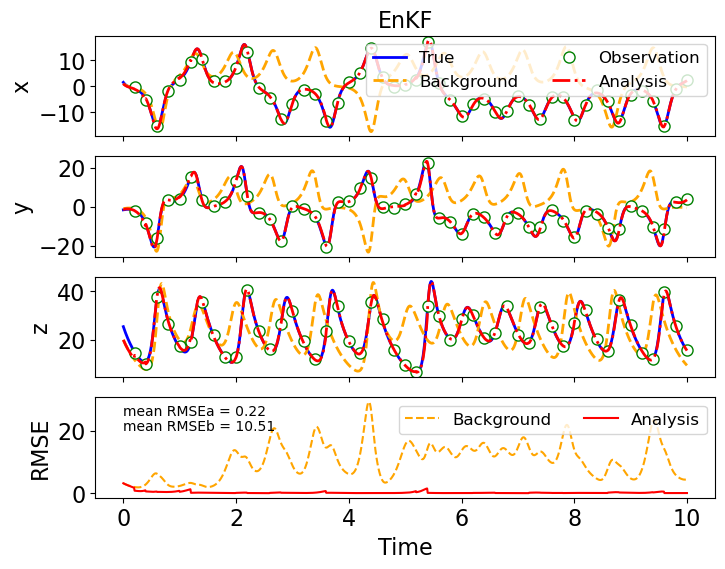

In [28]:
RMSEb = np.sqrt(np.mean((Xb-Xtrue)**2,0))
RMSEa = np.sqrt(np.mean((Xa-Xtrue)**2,0))
# 结果画图
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
lbs = ['x','y','z']
for j in range(3):
    plt.subplot(4,1,j+1)
    plt.plot(t,Xtrue[j],'b-',lw=2,label='True')
    plt.plot(t,Xb[j],'--',color='orange',lw=2,label='Background')
    plt.plot(t_m,yo[j],'go',ms=8,markerfacecolor='white',label='Observation')
    plt.plot(t,Xa[j],'-.',color='red',lw=2,label='Analysis')
    plt.ylabel(lbs[j],fontsize=16)
    plt.xticks(np.arange(0,10.1,2),[]);plt.yticks(fontsize=16)
    if j==0:
        plt.legend(ncol=2, loc='upper right',fontsize=12)
        plt.title("EnKF",fontsize=16)     #!!!!!!!!!!!!!!!!!!!!!!!!!!!
plt.subplot(4,1,4)
plt.plot(t,RMSEb,'--',color='orange',label='Background')
plt.plot(t,RMSEa,color='red',label='Analysis')
plt.text(0,20,'mean RMSEb = %0.2f' %np.mean(RMSEb))
plt.text(0,25,'mean RMSEa = %0.2f' %np.mean(RMSEa))
plt.ylabel('RMSE',fontsize=16)
plt.xlabel('Time',fontsize=16)
plt.xticks(fontsize=16);plt.yticks(fontsize=16)
plt.legend(ncol=2, loc='upper right',fontsize=12)

EnKF的同化效果优势就非常明显了。可以看出，EnKF的要点是积分整个集合，然后每当需要同化的时候，使用集合即时计算需要的$B$矩阵，进行同化更新，并且更新所有集合成员。

我们几乎采用了相同的框架开展同化实验，从3DVar，EKF和EnKF，这三个方法的差异只在毫厘之间，如果观察我在这三个实验的代码里面放的`!!!!!!!!!!!!!!!!!!!!!`，以3DVar为基准，我们可以看到：

1. EKF利用切线模式，额外增加了$B$的预报更新和$B$的分析更新。
2. EnKF不需要$B$的更新，但是它需要积分一个集合，同化的时候也需要更新所有集合成员。

其他的所有代码几乎都是一样的。

## EnKF的衍生算法

EnKF还是有其自身的不足的，一个典型的方面在EnKF函数的倒数第三行，`yoi[:,i] = yo + np.random.multivariate_normal(np.zeros(m), R)`意味着需要使用随机向量对观测进行扰动。凡是涉及随机的算法总有一定的不确定因素，相对来说没有那么可靠。而且，大型模式的扰动还涉及很多技巧，这是一个不方便的地方。扰动观测的原因涉及一些理论，我不打算在这里说明。

我想说的结论是，后续开发了一系列不需要扰动观测的确定性滤波器，包括EnSRF, ETKF, EAKF, DEnKF等等，我不具体介绍它们的原理，只把算法代码放在下面。读者可以在框[12]的EnKF同化实验中，在调用EnKF的一行换成调用这些函数，都能达到类似的同化效果。

In [14]:
#%% 集合平方根滤波器（直接法）
def EnSRF(xbi,yo,ObsOp,Dh,R):
    from scipy.linalg import sqrtm
    n,N = xbi.shape                      # n-状态维数，N-集合成员数
    m = yo.shape[0]                      # m-观测维数
    xb = np.mean(xbi,1)                   # 预报集合平均 
    B = (1/(N-1)) * (xbi - xb.reshape(-1,1)) @ (xbi - xb.reshape(-1,1)).T
    D = Dh@B@Dh.T + R
    K = B @ Dh.T @ np.linalg.inv(D)         # !!!以上与EnKF一致
    xa = xb + K @ (yo-ObsOp(xb))          # 用确定性格式更新集合平均

    A = xbi - xb.reshape(-1,1)              # 集合异常
    Z = A/np.sqrt(N-1)                    # 标准化集合异常值
    Y = np.linalg.inv(D)@Dh@Z           
    X = sqrtm(np.eye(N)-(Dh@Z).T@Y)      # 矩阵平方根
    X = np.real(X)                         # 保证矩阵平方根为实数
    
    Z = Z@X                             # 更新集合异常值
    A = Z*np.sqrt(N-1)
    xai = xa.reshape(-1,1)+A               # 用集合平均和集合异常计算集合成员
    return xai

In [15]:
#%% 集合平方根卡尔曼滤波器(串行格式)
def sEnSRF(xbi,yo,ObsOp,Dh,R):
    n,N = xbi.shape                     # n-状态维数，N-集合成员数
    m = yo.shape[0]                     # m-观测维数
    xb = np.mean(xbi,1)                 # 预报集合平均 
    B = (1/(N-1)) * (xbi - xb.reshape(-1,1)) @ (xbi - xb.reshape(-1,1)).T
    D = Dh@B@Dh.T + R
    K = B @ Dh.T @ np.linalg.inv(D)       # !!!以上与EnKF一致
    xa = xb + K @ (yo-ObsOp(xb))        # 用确定性格式更新集合平均

    A = xbi - xb.reshape(-1,1)            # 集合异常
    Z = A/np.sqrt(N-1)                  # 标准化集合异常值
    V = (Dh@Z).T
    for j in range(m):                       # 根据每个观测循环
        Dj = V[:,j].T @ V[:,j] + R[j,j] 
        betaj = 1/(Dj+np.sqrt(R[j,j]*Dj))
        Z = Z@(np.eye(N)-betaj*V[:,j]@V[:,j].T)     # 集合异常更新公式
    A = Z*np.sqrt(N-1)
    xai = xa.reshape(-1,1)+A               # 用集合平均和集合异常计算集合成员
    return xai

In [16]:
#%% 集合转换卡尔曼滤波器
def ETKF(xbi,yo,ObsOp,Dh,R):
    n,N = xbi.shape                      # n-状态维数，N-集合成员数
    m = yo.shape[0]                     # m-观测维数
    xb = np.mean(xbi,1)                  # 预报集合平均 
    B = (1/(N-1)) * (xbi - xb.reshape(-1,1)) @ (xbi - xb.reshape(-1,1)).T
    D = Dh@B@Dh.T + R
    K = B @ Dh.T @ np.linalg.inv(D)        # !!!以上与EnKF一致
    xa = xb + K @ (yo-ObsOp(xb))         # 用确定性格式更新集合平均

    A = xbi - xb.reshape(-1,1)             # 集合异常
    Z = A/np.sqrt(N-1)                   # 标准化集合异常值
    V = (Dh@Z).T
    CTC = V@np.linalg.inv(R)@V.T
    Gamma, C = np.linalg.eig(CTC)
    Gamma = np.real(Gamma);C = np.real(C)    
    Z = Z@C@np.diag((Gamma+1)**(-0.5))  # 集合异常更新公式
    A = Z*np.sqrt(N-1)
    xai = xa.reshape(-1,1)+A              # 用集合平均和集合异常计算集合成员
    return xai

In [17]:
#%% 集合调整卡尔曼滤波器
def EAKF(xbi,yo,ObsOp,Dh,R):
    n,N = xbi.shape                       # n-状态维数，N-集合成员数
    m = yo.shape[0]                      # m-观测维数
    xb = np.mean(xbi,1)                   # 预报集合平均 
    B = (1/(N-1)) * (xbi - xb.reshape(-1,1)) @ (xbi - xb.reshape(-1,1)).T
    D = Dh@B@Dh.T + R
    K = B @ Dh.T @ np.linalg.inv(D)          # !!!以上与EnKF一致
    xa = xb + K @ (yo-ObsOp(xb))           # 用确定性格式更新集合平均

    A = xbi - xb.reshape(-1,1)               # 集合异常
    Z = A/np.sqrt(N-1)                         # 标准化集合异常值
    V = (Dh@Z).T
    CTC = V@np.linalg.inv(R)@V.T
    Gamma, C = np.linalg.eig(CTC)
    Gamma = np.real(Gamma);C = np.real(C)   
    F,G,U = np.linalg.svd(Z)
    IG2 = np.diag((Gamma+1)**(-0.5))
    Gtilde = np.concatenate([np.diag(1/G),np.zeros([N-m,m])],0)   # !!!公式（6-1-29）
    Adj = Z@C@IG2@Gtilde@F.T                             # !!!公式（6-1-30）
    Z = Adj@Z                                              # 公式（6-1-27）                    
    A = Z*np.sqrt(N-1)
    xai = xa.reshape(-1,1)+A            # 用集合平均和集合异常计算集合成员
    return xai   

In [18]:
#%% 确定性集合卡尔曼滤波器
def DEnKF(xbi,yo,ObsOp,Dh,R):
    n,N = xbi.shape         # n-状态维数，N-集合成员数
    m = yo.shape[0]         # m-观测维数
    xb = np.mean(xbi,1)     # 预报集合平均 
    B = (1/(N-1)) * (xbi - xb.reshape(-1,1)) @ (xbi - xb.reshape(-1,1)).T
    D = Dh@B@Dh.T + R
    K = B @ Dh.T @ np.linalg.inv(D)     # !!!以上与EnKF一致
    xa = xb + K @ (yo-ObsOp(xb))        # 更新集合成员
    
    A = xbi - xb.reshape(-1,1)          # 集合异常
    A = A - (1/2) * K @ Dh @ A          # !! DEnKF关键步骤：补偿离散度的操作
    xai = xa.reshape(-1,1) + A
          
    return xai

In [19]:
#%% （串行）集合调整卡尔曼滤波器
def obs_increment_eakf(ensemble, observation, obs_error_var): # 1：计算观测空间增量
    prior_mean = np.mean(ensemble);
    prior_var = np.var(ensemble);
    if prior_var >1e-6:                                                 # 用于避免退化的先验集合造成错误更新
        post_var = 1.0 / (1.0 / prior_var + 1.0 / obs_error_var);       # 公式（2）
        post_mean = post_var * (prior_mean / prior_var + observation / obs_error_var);  # 公式（3）
    else:
        post_var = prior_var; post_mean = prior_mean;    
    updated_ensemble = ensemble - prior_mean + post_mean;
    var_ratio = post_var / prior_var;
    updated_ensemble = np.sqrt(var_ratio) * (updated_ensemble - post_mean) + post_mean; # 公式（4）
    obs_increments = updated_ensemble - ensemble;
    return obs_increments
def get_state_increments(state_ens, obs_ens, obs_incs): # 2将观测增量回归到状态增量
    covar = np.cov(state_ens, obs_ens);
    state_incs = obs_incs * covar[0,1]/covar[1,1];
    return state_incs
def sEAKF(xai,yo,ObsOp, R, RhoM):
    n,N = xai.shape;                  # 状态维数
    m = yo.shape[0];                  # 观测数
    Loc = ObsOp(RhoM)                 # 观测空间局地化
    for i in range(m):                # 针对每个标量观测的循环
        hx = ObsOp(xai);              # 投影到观测空间 
        hxi = hx[i];                  # 投影到对应的矢量观测
        obs_inc = obs_increment_eakf(hxi,yo[i],R[i,i]);
        for j in range(n):            # 针对状态变量的每个元素的循环
            state_inc = get_state_increments(xai[j], hxi,obs_inc)   # 获取状态增量
            cov_factor=Loc[i,j]       # 使用局地化矩阵的相应元素
            if cov_factor>1e-6:       # 在局地化范围内加增量
                xai[j]=xai[j]+cov_factor*state_inc; 
    return xai

## 结语

集合卡尔曼滤波器的那一堆衍生方法：集合平方根卡尔曼滤波器（EnSRF），集合转移卡尔曼滤波器（ETKF），集合调整卡尔曼滤波器（EAKF），确定性卡尔曼滤波器（DEnKF）等等，需要注意他们的名字都带“集合”以及“卡尔曼”，这说明它们的核心思想都是用集合的思想实现卡尔曼滤波器的那一套公式，只不过在公式实现的细节上采用了一些技巧。

这里最后提供的这个串行集合调整卡尔曼滤波器，虽然代码看上去复杂，但是实际执行中效率较高且节约内存，将是我后面采用的主要算法。里面涉及的局地化部分（即输入量`RhoM`，$\rho_M$）会在后面讨论，这里调用的时候可以暂时先使用一个全1矩阵代替。

在不是特别强调的情况下，集合卡尔曼滤波器这个词也会包括上面一系列的衍生算法，而最开始介绍的那个EnKF实质上是扰动观测的经典EnKF。
现实中不是特别有必要分得太细。

从3DVar到EKF到EnKF即衍生算法之路就介绍到这儿。每一种方法的提出都是为了解决前者的不足。然而，EnKF远远不是完美的，它的不足就需要由后继者来完善了。